# I] Import, options

In [1]:
import numpy, seaborn, pandas
import matplotlib, matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# II] Data Download

In [4]:
#data HEK293 all H3K4me3
df = pandas.read_csv(file_directory+'1) input/HEK293_H3K4me3_37KOvs37wt.csv',sep = ',')

# select columns
columns = ['SYMBOL','Fold','FDR','annotation']
print(df.shape)
df[columns].head(5)

(111048, 35)


,SYMBOL,Fold,FDR,annotation
0,GRK7,-9.033821,4.636942e-07,Promoter (<=1kb)
1,DYNLT2,-20.991616,4.636942e-07,Promoter (<=1kb)
2,LENG8-AS1,-20.908048,4.636942e-07,Promoter (<=1kb)
3,NSMCE3,-20.888045,4.636942e-07,Promoter (<=1kb)
4,LRRC37A4P,-20.868638,4.636942e-07,Promoter (<=1kb)


In [5]:
#p.value is probably not adj.p.value

# III] VolcanoPlot

In [6]:
#define the colors
df = df[df['FDR'] < 1]
colors = ['blue' if x < -5 and -numpy.log10(y) > 3
          else 'red' if x > 5 and -numpy.log10(y) > 3
          else 'black' if x > -1 and x < 1
          else 'grey' for x, y in zip(df['Fold'], df['FDR'])]

blue_indices = [symbol for symbol, color in zip(df['SYMBOL'], colors) if color == 'blue']
red_indices = [symbol for symbol, color in zip(df['SYMBOL'], colors) if color == 'red']
grey_indices = [symbol for symbol, color in zip(df['SYMBOL'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

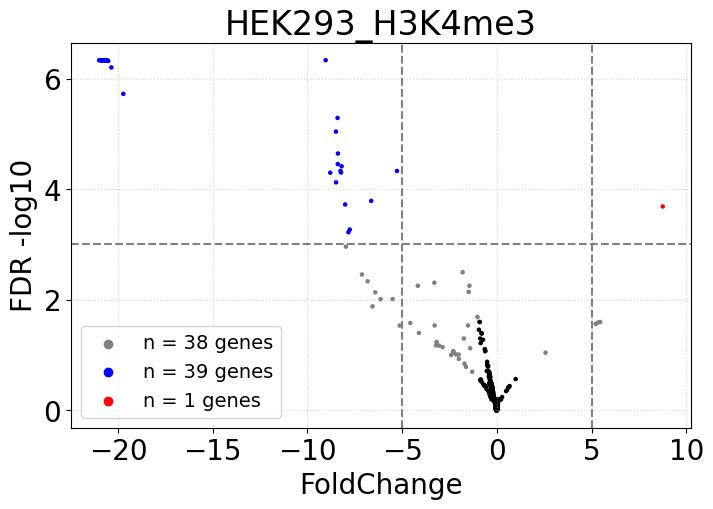

In [7]:
#volcano plot
# Plot, after convertion  y to log10(pvalue)
plt.scatter(x=df['Fold'],y=df['FDR'].apply(lambda x:-numpy.log10(x)),
            s=5,  c=colors)

plt.scatter(x=[],y=[], marker="o", color='grey', label= f'n = {grey_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = {blue_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = {red_genes_n} genes')

plt.legend(fontsize = '14')
plt.title('HEK293_H3K4me3')
plt.xlabel("FoldChange")
plt.ylabel("FDR -log10")

plt.axvline(-5,color="grey",linestyle="--")
plt.axvline(5,color="grey",linestyle="--")
plt.axhline(3,color="grey",linestyle="--")

title_file = 'volcano_HEK293_H3K4me3_37KOvs37wt'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

## IV] Heatmap

In [8]:
df.shape

(10779, 35)

In [9]:
#select the interesting genes
df_hm = df[ (df['Fold'] > 5) | (df['Fold'] < -5) ]

log_p_value = 3
p_value = 10**(-log_p_value)

df_hm = df_hm[ (df_hm['p.value'] < p_value) ]
print(f"highest pvalue is {df_hm['p.value'].max()}")

df_hm = df_hm[['SYMBOL', 'Fold','p.value']]
print(df_hm.shape)
# save this results
df_hm.to_csv('{}/1) input/from_output/highest_HEK293_H3K4me3_37KOvs37wt.csv'.format(file_directory), sep=',')
df_hm.head()

highest pvalue is 0.0001684708948245
(51, 3)


,SYMBOL,Fold,p.value
0,GRK7,-9.033821,6.849668e-11
1,DYNLT2,-20.991616,4.086203e-10
2,LENG8-AS1,-20.908048,4.799091e-10
3,NSMCE3,-20.888045,4.985701e-10
4,LRRC37A4P,-20.868638,5.173504e-10


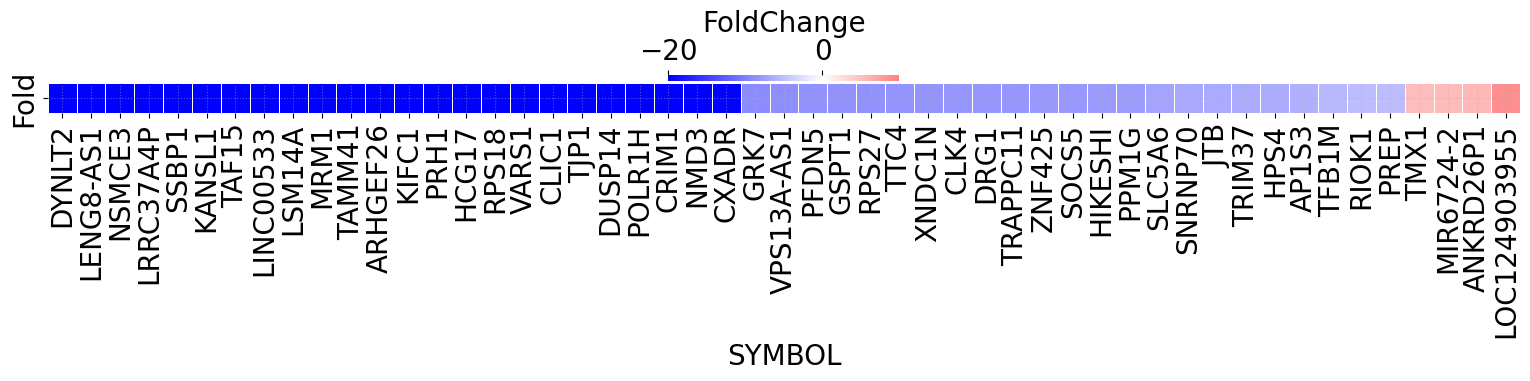

In [10]:
data = df_hm[['SYMBOL','Fold']]
data = data.sort_values(['Fold'], ascending = True)
data.set_index('SYMBOL', inplace= True)

plt.subplots(figsize=(19,0.5))
seaborn.heatmap(data.T, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=-20, vmax=10,
               cbar_kws={'label': 'FoldChange', 'location' : 'top', 'orientation': 'horizontal',
                        'aspect': 40})

title_file = 'Heatmap_HEK293_H3K4me3_37KOvs37wt'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [11]:
# save the list to csv
df_hm.sort_values(['Fold'], ascending = True)
df_hm.to_csv('{}/1) input/from_output/HEK293_H3K4me3_37KOvs37wt_topgenes.csv'.format(file_directory), 
             index= False, sep=',')

# V] Classification by annotation

In [12]:
#to see the different kind of annotation 
# set(df.annotation)

In [13]:
# create a function to simplufy the annotation
def get_annotation_category(annotation):
    if annotation.startswith('Intron'):
        return 'Intron'
    elif annotation.startswith('Exon'):
        return 'Exon'
    elif annotation.startswith('Promoter'):
        return 'Promoter'
    else:
        return annotation

In [14]:
df = df.assign(Annotation = df['annotation'].apply(get_annotation_category))
df = df[['SYMBOL', 'Fold', 'p.value', 'FDR', 'Annotation']]
print(set(df.Annotation), '\n')

df['Annotation'] = df['Annotation'].str.strip()
df

{"5' UTR", "3' UTR", 'Intron', 'Downstream (<=300bp)', 'Promoter', 'Distal Intergenic', 'Exon'} 



,SYMBOL,Fold,p.value,FDR,Annotation
0,GRK7,-9.033821,6.849668e-11,4.636942e-07,Promoter
1,DYNLT2,-20.991616,4.086203e-10,4.636942e-07,Promoter
2,LENG8-AS1,-20.908048,4.799091e-10,4.636942e-07,Promoter
3,NSMCE3,-20.888045,4.985701e-10,4.636942e-07,Promoter
4,LRRC37A4P,-20.868638,5.173504e-10,4.636942e-07,Promoter
...,...,...,...,...,...
10774,CRYBB2P1,-0.000016,9.995154e-01,9.998732e-01,Promoter
10775,LINC02043,0.000010,9.996038e-01,9.998732e-01,Promoter
10776,LINC02716,0.000008,9.996930e-01,9.998732e-01,Promoter
10777,SPAG9,0.000007,9.997806e-01,9.998732e-01,Promoter


In [15]:
df

,SYMBOL,Fold,p.value,FDR,Annotation
0,GRK7,-9.033821,6.849668e-11,4.636942e-07,Promoter
1,DYNLT2,-20.991616,4.086203e-10,4.636942e-07,Promoter
2,LENG8-AS1,-20.908048,4.799091e-10,4.636942e-07,Promoter
3,NSMCE3,-20.888045,4.985701e-10,4.636942e-07,Promoter
4,LRRC37A4P,-20.868638,5.173504e-10,4.636942e-07,Promoter
...,...,...,...,...,...
10774,CRYBB2P1,-0.000016,9.995154e-01,9.998732e-01,Promoter
10775,LINC02043,0.000010,9.996038e-01,9.998732e-01,Promoter
10776,LINC02716,0.000008,9.996930e-01,9.998732e-01,Promoter
10777,SPAG9,0.000007,9.997806e-01,9.998732e-01,Promoter


In [16]:
df.Annotation.value_counts()

Promoter                8355
Intron                  1416
Distal Intergenic        845
Exon                     104
3' UTR                    54
Downstream (<=300bp)       3
5' UTR                     2
Name: Annotation, dtype: int64

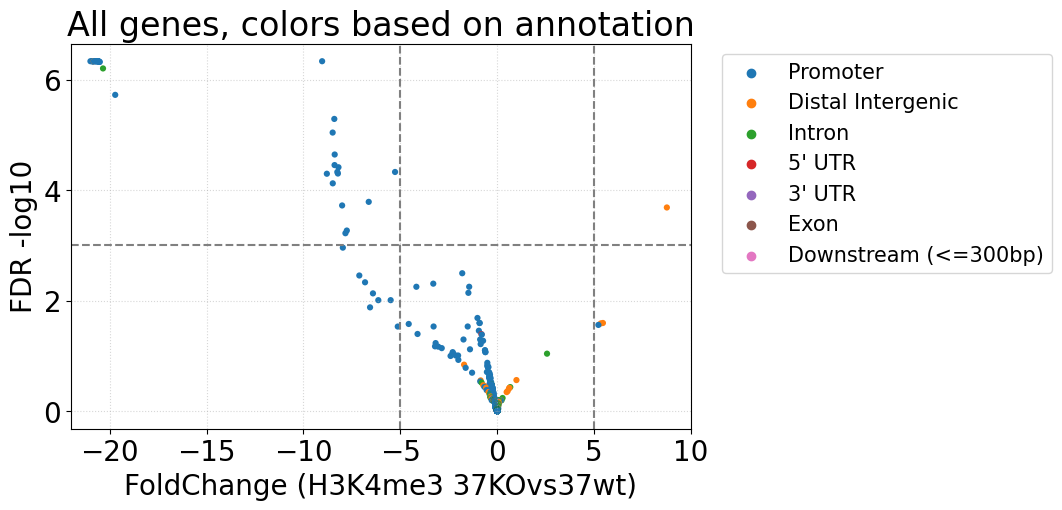

In [17]:
seaborn.scatterplot(data=df, x=df['Fold'], 
                    y=df['FDR'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Annotation")

plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1), fontsize='15')

plt.title('All genes, colors based on annotation')
plt.xlim(-22, 10)
plt.xlabel("FoldChange (H3K4me3 37KOvs37wt)")
plt.ylabel("FDR -log10")

plt.axvline(-5,color="grey",linestyle="--")
plt.axvline(5,color="grey",linestyle="--")
plt.axhline(3,color="grey",linestyle="--")

title_file = 'volcano_HEK293_H3K4me3_37KOvs37wt_all_annotation'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [18]:
# Check up to see if its true (yes, the colors fit to the annotation)
log_p_value = 3
p_value = 10**(-log_p_value)

df_ctl = df[ (df['Fold'] > 1) & (df['FDR'] < p_value)]
df_ctl.sort_values('Fold').head()

,SYMBOL,Fold,p.value,FDR,Annotation
37,LOC124903955,8.758755,7.233005e-07,0.000206,Distal Intergenic


In [19]:
import scipy, scipy.stats

In [20]:
# Create a DataFrame
# Calculate Pearson correlation coefficient between p-value and annotation encoding
r_value, p_value = scipy.stats.spearmanr(df['FDR'], df['Annotation'])

print(f'Correlation coefficient: {r_value}')
print(f'P-value: {p_value}')

Correlation coefficient: 0.0575123960903924
P-value: 2.2966251453005924e-09
